# PHM North America challenge '23

# 01 - Data Exploration

This notebook briefly describes the dataset and the problem statement for the PHM North America challenge '23. The complete dataset and original problem descriptions are available on the [PHM Society website](https://data.phmsociety.org/phm2023-conference-data-challenge/). Note that for our purposes, we will only be using the training dataset (as labels are only available for the training dataset).

## Problem description: Gear pitting

Gear pitting is a surface fatigue failure of the gear tooth. It occurs due to repeated loading of tooth surface and the contact stress exceeding the surface fatigue strength of the material. Material in the fatigue region gets removed and a pit is formed. The pit itself will cause stress concentration and soon the pitting spreads to adjacent region till the whole surface is covered [[source](https://gearsmechon.wordpress.com/pitting-of-gears/)].

## Dataset description

The **training** dataset includes measurements under varied operating conditions from a healthy state as well as six known fault levels. The **testing and validation** datasets contain data from eleven health levels. Data from some fault levels and operating conditions are excluded from the training datasets to mirror real-world conditions where data collection may only be available from a subset of full range of operation. The training data are collected from a range of different operating conditions under 15 different rotational speeds and 6 different torque levels. Test and validation data operating conditions span 18 different rotational speeds and 6 different torque levels.

[[source](https://data.phmsociety.org/phm2023-conference-data-challenge/)]

<img src="https://data.phmsociety.org/wp-content/uploads/sites/9/2023/06/PHM2023dc_fig1.png" alt="MarineGEO circle logo" style="height: 375px; width:800px;"/>

<img src="https://data.phmsociety.org/wp-content/uploads/sites/9/2023/06/PHM2023dc_fig2.png" alt="MarineGEO circle logo" style="height: 300px; width:800px;"/>



In [11]:
%load_ext autoreload
%autoreload 2

from conscious_engie_icare.viz.spectrogram import plot_stft, plot_periodogram, plot_welch
from conscious_engie_icare.data.phm_data_handler import BASE_PATH_HEALTHY, FILE_NAMES_HEALTHY, load_train_data, \
    fetch_and_unzip_data, extract_process_parameters, load_data, load_cached_data, BASE_PATHS_TEST

import os
import pandas as pd
import glob
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first load the data and examine the structure of the dataset.
The academic dataset consists of 7 folders (`Pitting_degradation_level_<level>`).

In [3]:
fetch_and_unzip_data()

'../data/Data_Challenge_PHM2023_training_data'

# Vibration data

The vibration data is given in the time domain and is briefly described in the following subsection.
As the frequency domain is used, we will convert the time domain data to the frequency domain thereafter.

## Time domain

We load the vibration dataset and examine a single vibration measurement below. The vibration signal sampling rate is 20480Hz. The sampling duration differs between 3 seconds and 12 seconds. 
For each vibration measurement there are triaxial time-domain vibration measurements available (`x`, `y` and `z`).

A single sample (rpm=100, torque=500, run=1) has the following shape:
(246785, 4)


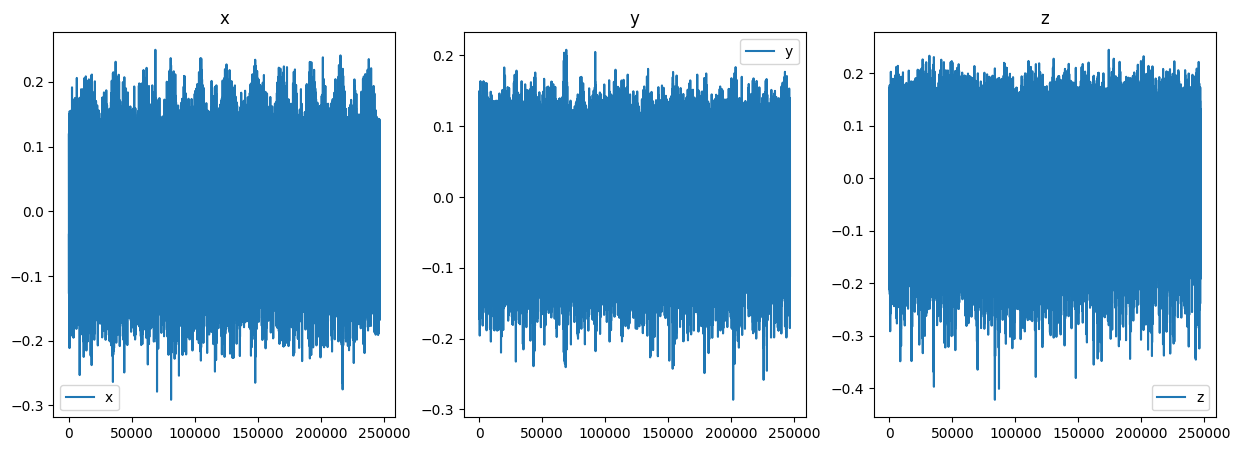

In [4]:
rpm = 100
torque = 500
run = 1
df_example = load_train_data(rpm, torque, run)
print(f"A single sample (rpm={rpm}, torque={torque}, run={run}) has the following shape:")
print(df_example.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for var, ax in zip(['x', 'y', 'z'], axes):
    ax.plot(df_example[var], label=var)
    ax.set_title(var)
    ax.legend()

## Frequency domain

We visualize the data in the vibration data in frequency domain in this subsection. First, we calculate an short-time Fourier transform (STFT), to visualize the stationarity of the signal. We then calculate the power spectral density (PSD) of the signal to visualize the frequency content of the signal.

### STFT

Vibration Sampling Frequency = 20480 Hz [[source](https://data.phmsociety.org/phm2023-conference-data-challenge/)].

The STFT divides the signal into overlapping segments and calculates a Fourier Transform for each segment.
It provides a localized view on the signal which is particularly useful for signals where the frequency components change over the measurement period.

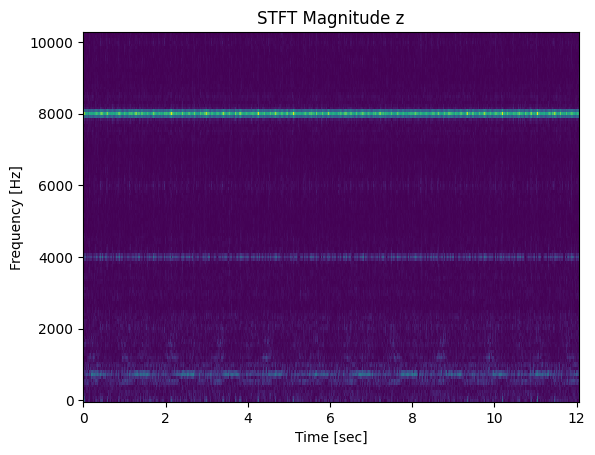

In [5]:
plot_stft(df_example, 'z', nperseg=None, fs=20480)

As we expect that within each measurement there are no changes in the frequency components, we also check the periodogram below.

### Spectral density estimation

A periodogram is an estimate of the spectral density of a signal [[source](https://en.wikipedia.org/wiki/Periodogram)].
We use Welch's method.
**The primary idea behind Welch's method is to divide the original signal into overlapping segments, calculate the periodogram for each segment, and then average these periodograms to obtain a more stable estimate of the PSD.** This approach helps to reduce the variance and noise inherent in the standard periodogram.
Below, we visualize the periodogram for a triaxual measurement (x, y and z directions) at 200 rpm and a torque of 300 Nm.
The same peaks that are visible in the STFT at 4000 Hz and 8000 Hz are also visible in the periodogram. 

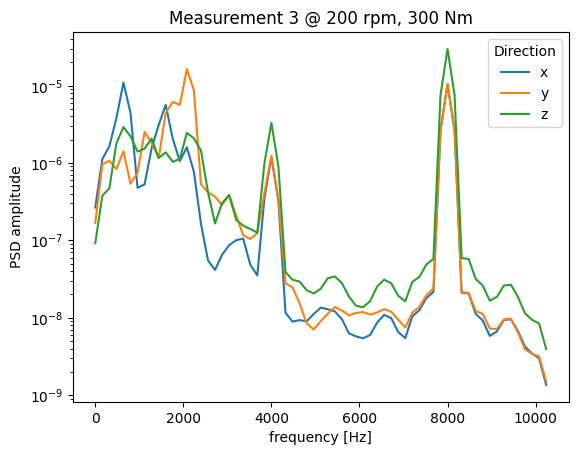

In [6]:
rpm=200
torque=300
run=3

df_example = load_train_data(rpm=rpm, torque=torque, run=run)
plot_welch(df_example, 'x', nperseg=128, fs=20480)
plot_welch(df_example, 'y', nperseg=128, fs=20480)
plot_welch(df_example, 'z', nperseg=128, fs=20480)
plt.title(f'Measurement {run} @ {rpm} rpm, {torque} Nm');
plt.legend(['x', 'y', 'z'], title='Direction');

# Process data

In contrast to the industrial feedwater pump use case, **operating conditions are very stable in the given dataset**.
Therefore, clustering of operating modes based on a separate set of process paramters is not necessary.
Instead, we will perform a mapping based on the combination of rotational speed (V) and torque (N).
The table below contains the mapping of the operating conditions for the 287 measurements from the training dataset.

In [7]:
len(FILE_NAMES_HEALTHY)

287

In [16]:
all_unhealthy_files = [glob.glob(os.path.join(fpath, '*')) for fpath in BASE_PATHS_TEST]
def flatten(xss):
    return [x for xs in xss for x in xs]
all_unhealthy_files = flatten(all_unhealthy_files)
len(all_unhealthy_files)

1729

In [7]:
data = []
for file_path in FILE_NAMES_HEALTHY:
    v_value, n_value, sample_number = extract_process_parameters(file_path)
    data.append({
        'V': v_value,  # Remove the 'V' prefix and convert to integer
        'N': n_value,  # Remove the 'N' suffix and convert to integer
        'SampleNumber': sample_number  # Remove the '.txt' extension and convert to integer
    })

df_process = pd.DataFrame(data)

print("--- Healthy data (pitting level 0) ---")
print(f"Number of samples: {len(df_process)}")
print(f"Number of unique RPM values: {len(df_process['V'].unique())}")
print(f"Number of unique torque values: {len(df_process['N'].unique())}")
print(f"Number of unique sample numbers: {len(df_process['SampleNumber'].unique())}")
df_process.head()

--- Healthy data (pitting level 0) ---
Number of samples: 287
Number of unique RPM values: 15
Number of unique torque values: 6
Number of unique sample numbers: 5


,V,N,SampleNumber
0,200,500,3
1,600,300,5
2,200,50,3
3,1200,200,2
4,100,200,5


There are 77 unique combinations of rotational speed and torque in the training dataset.
Each combination has 1-5 samples.

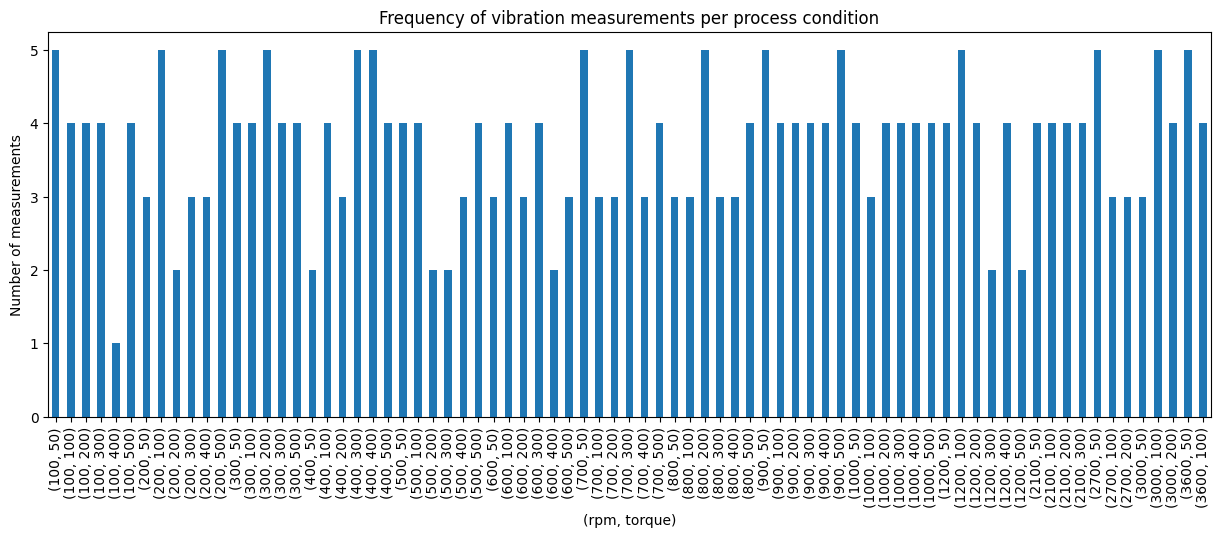

In [8]:
# get the unique number of combinations of RPM and torque
df_runs = df_process.groupby(['V', 'N']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(15, 5))
df_runs.index = list(zip(df_runs.V, df_runs.N))
df_runs['counts'].plot.bar(ax=ax)
ax.set_ylabel('Number of measurements')
ax.set_xlabel('(rpm, torque)')
ax.set_title('Frequency of vibration measurements per process condition');

©, 2023, Sirris